In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchinfo import summary

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from model import ConvolutionalNetwork

# Loading the MNIST dataset

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 11114387.41it/s]


Extracting ../Data\MNIST\raw\train-images-idx3-ubyte.gz to ../Data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1848694.30it/s]

Extracting ../Data\MNIST\raw\train-labels-idx1-ubyte.gz to ../Data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11265574.95it/s]


Extracting ../Data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../Data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../Data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../Data\MNIST\raw



### Creating data loaders
As working with images we want relatively small batches.

In [3]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
# creating instance of model 
torch.manual_seed(42) # seeding so we can replicate out results

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
summary(model,(10,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionalNetwork                     [10, 10]                  --
├─Conv2d: 1-1                            [10, 6, 26, 26]           60
├─Conv2d: 1-2                            [10, 16, 11, 11]          880
├─Linear: 1-3                            [10, 120]                 48,120
├─Linear: 1-4                            [10, 84]                  10,164
├─Linear: 1-5                            [10, 10]                  850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
Total mult-adds (M): 2.06
Input size (MB): 0.03
Forward/backward pass size (MB): 0.50
Params size (MB): 0.24
Estimated Total Size (MB): 0.77

# Defining loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Training the Model

In [9]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    loss_train = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
        loss_train += loss.detach()

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f} \ accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss_train/len(train_loader))
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed     

epoch:  0  batch:  600 [  6000/60000]  loss: 0.25808319 \ accuracy:  78.750%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.12558192 \ accuracy:  85.983%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.03896422 \ accuracy:  88.944%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.20835188 \ accuracy:  90.596%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.58307952 \ accuracy:  91.683%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.13294105 \ accuracy:  92.506%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.01490034 \ accuracy:  93.107%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00728325 \ accuracy:  93.648%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00872792 \ accuracy:  94.037%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.03737647 \ accuracy:  94.393%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01177949 \ accuracy:  97.733%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.02433350 \ accuracy:  97.867%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.01315395 \ accuracy:  97.856%

# Plot of loss and accuracy comparison

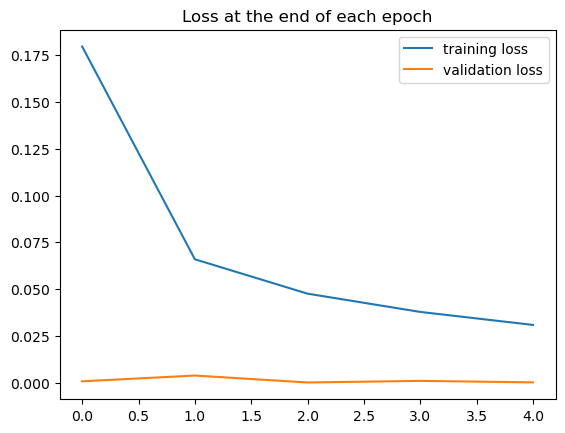

In [10]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()